# Мера контрастности tf-idf для выделения ключевых слов. Векторная модель текста. Снижение размерности в векторной модели. Совсем простой поиск


## Мера контрастности $tf-idf$ для выделения ключевых слов

Рассмотрим коллекцию текстов о ягуарах. Ягуар – это омоним, имеет несколько значений: животное, название напитка, название автомобильной марки, название фильма и модель швейной машины. На каждое из 5 значений слова у нас есть по 5 текстов. Для каждого из 5 значений слова мы можем найти в коллекции свои, специфические слова. 

Для начала объединим каждые 5 текстов в один текст, получим коллекцию из 5 текстов, каждый посвящен своему значению. 

In [1]:
path = '../data/jaguar'
raw_collection = []
for i in range(1,6):
    cur_path = path + str(i) + '/'
    cur_collection = []
    for j in range(1,6):
        lines = open(cur_path+str(j)+'.txt').readlines()
        cur_collection.append(lines[0].decode('utf-8'))
    merged_text = ' '.join(cur_collection)
    print merged_text[:100]
    raw_collection.append(merged_text)
print len(raw_collection)

Ягуар (Panthera onca) — вид хищных млекопитающих семейства кошачьих, один из четырёх представителей 
Jaguar (напиток) Jaguar Слабоалкогольный газированный энергетический напиток Алюминиевая банка напит
Британская автомобилестроительная компания Jaguar Cars производит легковые автомобили Jaguar класса 
Франсис Вебер — это знаковая фигура во французском, да и в европейском кино в общем. Посудите сами: 
Инструкция для швейной машины Mini Jaguar Инструкция швейной машины Mini Jaguar Швейная машинка "Мин
5


Проведем стандартную предобработку.

In [5]:
from string import punctuation
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
exclude = set(punctuation + u'0123456789[]—«»–')
from pymorphy2 import MorphAnalyzer

def preprocess(text):
    buf = ''.join(ch for ch in text if ch not in exclude)
    tokens = WhitespaceTokenizer().tokenize(buf.lower())
    lemmatizer = MorphAnalyzer()
    lemmas = []
    for t in tokens[:]:
        if not t in stopwords.words('russian'):
            try:
                lemma = lemmatizer.parse(t)[0].normal_form
            except: 
                lemma = t
#             print t, type(t), lemma
            lemmas.append(lemma)
    return lemmas

# lemmatizer = MorphAnalyzer()    
# print lemmatizer.parse(u'фильмы')[0].normal_form 

Используем реализации $tf-idf$ из NLTK для поиска ключевых слов в каждом тексте. Существенный недостаток этой реализации – скорость.

In [6]:
collection = [preprocess(text) for text in raw_collection]
from nltk.text import TextCollection
from nltk.corpus import stopwords 
cur_text = 1
buf = []
corpus = TextCollection(collection)
for i in set(collection[cur_text]):
    buf.append([ i, corpus.tf_idf(i, collection[cur_text])])
for i in sorted(buf,key=lambda l:l[1], reverse=True)[:20]:
    print i[0], i[1]

напиток 0.0466676002543
алкоголь 0.0176280165655
банка 0.0149838140807
энергетический 0.0132210124242
вред 0.0114582107676
е 0.0105768099393
организм 0.00969540911105
слабоалкогольный 0.00969540911105
печень 0.00881400828277
краситель 0.00793260745449
кофеин 0.00705120662622
консервант 0.00705120662622
вопрос 0.00705120662622
содержимый 0.00705120662622
содержание 0.00616980579794
энергия 0.00616980579794
давать 0.00616980579794
алкогольный 0.00551982368599
человек 0.00531527209833
коктейль 0.00528840496966


# Векторная модель текста

Вернемся к исходным 25 текстам и снова проведем стандартную обработку. 

In [7]:
path = '../data/jaguar'
raw_collection = []
for i in range(1,6):
    cur_path = path + str(i) + '/'
    for j in range(1,6):
        lines = open(cur_path+str(j)+'.txt').readlines()
        raw_collection.append(lines[0].decode('utf-8'))
print len(raw_collection)
collection = [preprocess(text) for text in raw_collection]

25


Теперь вычислим косинусную меру сходства между всеми текстами с помощью библиотеки gensim.

In [21]:
from gensim import corpora, models, similarities
import numpy as np

dictionary = corpora.Dictionary(collection)
corpus = [dictionary.doc2bow(t) for t in collection]
tfidf = models.TfidfModel(corpus) 
corpus_tfidf = tfidf[corpus]
index = similarities.MatrixSimilarity(tfidf[corpus])
sims = index[corpus_tfidf]
print np.around(sims, decimals = 2)


[[ 1.          0.22        0.40000001  0.31        0.25        0.04        0.04
   0.05        0.03        0.05        0.03        0.02        0.03        0.03
   0.01        0.05        0.03        0.01        0.03        0.05        0.01
   0.01        0.02        0.02        0.04      ]
 [ 0.22        1.          0.22        0.28999999  0.18000001  0.01        0.03
   0.03        0.02        0.02        0.01        0.01        0.01        0.02
   0.01        0.02        0.03        0.02        0.02        0.04        0.01
   0.03        0.01        0.02        0.03      ]
 [ 0.40000001  0.22        1.          0.34        0.23999999  0.02        0.02
   0.03        0.01        0.02        0.01        0.01        0.01        0.02
   0.01        0.02        0.02        0.01        0.02        0.03        0.01
   0.01        0.01        0.01        0.03      ]
 [ 0.31        0.28999999  0.34        1.          0.22        0.02        0.02
   0.03        0.01        0.02        0.01    

Так как сама по себе матрица не очень понятна, построим по ней диаграмму близости. 

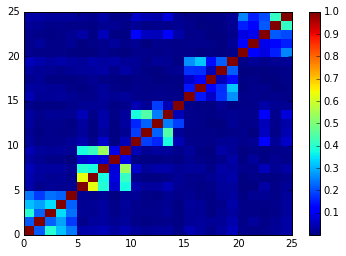

In [22]:
from pylab import pcolor, show, colorbar, xticks, yticks
%matplotlib inline

pcolor(sims)
colorbar()
show()

А теперь используем ЛСА, снизим количество размерностей до 10, пересчитаем и перерисуем матрицу близости.

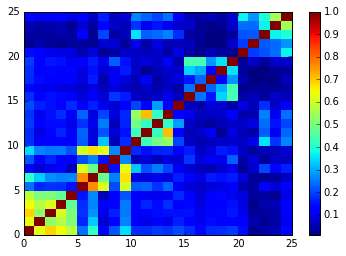

In [19]:
lsi = models.LsiModel(corpus, num_topics=10) 
corpus_lsi = lsi[corpus]
index = similarities.MatrixSimilarity(lsi[corpus])
sims = index[corpus_lsi]
pcolor(sims)
colorbar()
show()

# Задание 1

Создайте собственную коллекцию текстов. Найдите ключевые слова для каждого текста по мере $tf-idf$. Объясните принцип создания коллекции и полученные результаты. 

# Задание 2

Найдите ключевые биграммы для каждого текста по мере $tf-idf$. 


# Литература

* Manning & Raghavan & Schütze (IRbook) – Ch. 6.2.2 – Tf-idf weighting (http://nlp.stanford.edu/IR-book/html/htmledition/tf-idf-weighting-1.html)

* Manning & Raghavan & Schütze (IRbook) – Ch. 18 – Matrix decompositions and latent semantic indexing

* NLTK (плохая документация):  http://www.nltk.org/api/nltk.html#nltk.text.TextCollection

* http://www.tfidf.com/

* Gensim (документация и туториал): https://radimrehurek.com/gensim/

# Совсем простой поиск

In [23]:
doc = u"машина"
vec_bow = dictionary.doc2bow(preprocess(doc))
vec_tfidf = tfidf[vec_bow] 
sims = index[vec_tfidf]
sim_list = sorted(enumerate(sims), key=lambda item: -item[1])
for i in sim_list:
    if i[1] > 0:
        print i

(22, 0.31049913)
(20, 0.082851298)
(14, 0.06384252)
(24, 0.061500318)
(21, 0.05592959)
(12, 0.026284507)
(23, 0.024860036)
(11, 0.020495294)
(10, 0.018246267)
(13, 0.012472699)


In [24]:
doc = u"хороший ягуар"
vec_bow = dictionary.doc2bow(preprocess(doc))
vec_tfidf = tfidf[vec_bow] 
sims = index[vec_tfidf]
sim_list = sorted(enumerate(sims), key=lambda item: -item[1])
for i in sim_list:
    if i[1] > 0:
        print i

(12, 0.04919038)
(21, 0.049018715)
(0, 0.026228026)
(2, 0.025527325)
(8, 0.024278589)
(13, 0.023342146)
(18, 0.021240572)
(19, 0.020806178)
(15, 0.018771263)
(24, 0.013058485)
(1, 0.012685684)
(6, 0.01104558)
(23, 0.010894117)
(4, 0.010166726)
(3, 0.0085646911)
(9, 0.0082896547)
(5, 0.0042626057)
(14, 0.0037854419)
(10, 0.0028850231)
(20, 0.0026609576)
(17, 0.0025049341)
(16, 0.0017894759)
(11, 0.0016203149)


# Тематические модели

In [34]:
lsi = models.lsimodel.LsiModel(corpus=corpus, id2word=dictionary, num_topics = 10)
for topic in lsi.print_topics(5):
    print topic
    print '***'

0.614*"ягуар" + 0.216*"год" + 0.146*"нитка" + 0.141*"напиток" + 0.137*"jaguar" + 0.132*"который" + 0.129*"свой" + 0.121*"человек" + 0.120*"швейный" + 0.112*"машинка"
***
-0.341*"нитка" + -0.263*"швейный" + 0.261*"ягуар" + -0.241*"машинка" + -0.228*"лапка" + -0.209*"машин" + -0.182*"строчка" + -0.170*"шпулька" + -0.138*"jaguar" + -0.135*"верхний"
***
-0.390*"фильм" + 0.289*"ягуар" + -0.273*"вебер" + -0.241*"это" + -0.194*"свой" + -0.175*"герой" + -0.168*"который" + -0.139*"перрен" + -0.121*"ришар" + -0.119*"дуэт"
***
-0.322*"jaguar" + -0.321*"год" + 0.237*"нитка" + -0.213*"модель" + 0.188*"фильм" + -0.169*"компания" + -0.158*"напиток" + -0.145*"автомобиль" + 0.138*"шпулька" + 0.131*"вебер"
***
-0.701*"напиток" + -0.119*"алкоголь" + -0.119*"банка" + -0.099*"энергетический" + 0.099*"машинка" + -0.095*"е" + -0.092*"вред" + -0.090*"человек" + -0.087*"нитка" + -0.082*"слабоалкогольный"
***


In [41]:
lda = models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics = 15)
for topic in lda.print_topics(5):
    print topic
    print '***'

0.014*ягуар + 0.007*jaguar + 0.007*год + 0.006*швейный + 0.005*который + 0.005*машинка + 0.004*машин + 0.004*свой + 0.004*модель + 0.004*строчка
***
0.024*ягуар + 0.008*год + 0.005*свой + 0.005*это + 0.004*нитка + 0.004*фильм + 0.004*животный + 0.004*человек + 0.004*который + 0.003*самка
***
0.014*ягуар + 0.009*год + 0.007*который + 0.006*jaguar + 0.005*модель + 0.005*фильм + 0.005*иметь + 0.004*напиток + 0.004*это + 0.004*автомобиль
***
0.015*ягуар + 0.012*напиток + 0.006*год + 0.005*это + 0.004*свой + 0.004*который + 0.004*jaguar + 0.003*один + 0.003*стать + 0.003*человек
***
0.016*ягуар + 0.005*напиток + 0.004*год + 0.004*человек + 0.004*пятно + 0.004*чёрный + 0.003*jaguar + 0.003*также + 0.002*вод + 0.002*это
***
